# Предсказание ухода клиента (kaggle.com) <a class="tocSkip">

##### Вводная: <a class="tocSkip">
    
После успешного создания модели предсказания тарифов у вас появляется свободное время на улучшение своих навыков. По совету своих коллег вы решаете принять участие в соревновании на kaggle.com. Выбор падает на кейс по предсказанию ухода клиентов из крупного европейского банка. 
    
Основная задача: определить, останется ли клиент в банке или же разорвёт контракт. Для этого вам предоставлены обезличенные данные о клиентах и их поведении.

Скоринг в этом соревновании производится F1-мерой, поэтому нужно попытаться получить её как можно выше. Чтобы попасть на лидерборд F1-score должен быть больше 0.59. Тестирование модели необходимо проводить самостоятельно на открытых данных.
    
Также, поскольку решается реальный кейс, банк попросил измерять и *AUC-ROC*. 
     
Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


### Цель <a class="tocSkip">

Построить модель, которая спрогнозирует уход клиента из банка. Её F1-score должен быть больше 0.59.

### Описание данных <a class="tocSkip">

Обозначение | Признак
:---|:---
RowNumber | индекс строки в данных
CustomerId | уникальный идентификатор клиента
Surname | фамилия
CreditScore | кредитный рейтинг
Geography | страна проживания
Gender | пол
Age | возраст
Tenure | количество недвижимости у клиента
Balance | баланс на счёте
NumOfProducts | количество продуктов банка, используемых клиентом
HasCrCard | наличие кредитной карты
IsActiveMember | активность клиента
EstimatedSalary | предполагаемая зарплата
**Exited** | факт ухода клиента (**Целевой признак**)

### План <a class="tocSkip">

Шаг 1. [Подготовка данных](#step1)
   - Обработка дубликатов
   - Обработка пропусков
   - Кодировка признаков
   - Разделили данных на обучающую, валидационную и тестовую выборки
   - Нормализация количественных признаков
   
Шаг 2. [Исследование задачи](#step2)

Шаг 3. [Борьба с неравенством классов](#step3)
    
Шаг 4. [Проверка качества модели на тестовой выборке и проверка на адекватность](#step4)

Шаг 5. [Общий вывод](#step5)

## 0. Установка библиотек <a class="tocSkip">

In [1]:
%pip install dill
%pip install seaborn>=0.11 -U
%pip install scikit-learn -U
%pip install pactools
#%pip install mne h5py

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.24.1)
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import dill 

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder 
from sklearn.utils import shuffle

from pactools.grid_search import GridSearchCVProgressBar

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (f1_score, roc_curve, roc_auc_score, confusion_matrix, 
                             classification_report, plot_confusion_matrix, 
                             precision_score, recall_score)

from sklearn.dummy import DummyClassifier

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

#фильтр предупреждений
import warnings
warnings.simplefilter("ignore")

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.7/site-packages/ipywidgets/widgets/widget_selection.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, Iterable


In [3]:
#зададим ramdom seed
RS = 2021

## 1. Подготовка данных <a id='step1'></a>

In [4]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Есть лишний столбец RowNumber с индексами от которого можно избавиться 

In [5]:
data.drop(['RowNumber'], axis = 1, inplace=True)

Для удобства приведем названия столбцов к нижнему регистру.

In [6]:
data.columns = data.columns.str.lower()

#### Обработка дубликатов

In [7]:
data.duplicated().sum()

0

Также проверим повторяются ли клиенты в датасете, если нет – удалим колонку для того, чтобы наши предсказательные модели не считали её за признак.

In [8]:
data['customerid'].duplicated().sum()

0

In [9]:
data.drop(['customerid'], axis = 1, inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             9091 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(6), object(3)
memory usage: 937.6+ KB


Судя по полученной информации мы имеем большое количество пропущенных значений в столбце с недвижимостью.
Все типы данных определились адекватно задаче. Однако предстоит обработать некоторые категориальные (фамилия, пол, страна) и количественные признаки. 

In [11]:
#для наглядности установим отображение 1 знака после запятой
pd.set_option('precision', 1)

data.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.0,10000.0,9091.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,650.5,38.9,5.0,76485.9,1.5,0.7,0.5,100090.2,0.2
std,96.7,10.5,2.9,62397.4,0.6,0.5,0.5,57510.5,0.4
min,350.0,18.0,0.0,0.0,1.0,0.0,0.0,11.6,0.0
25%,584.0,32.0,2.0,0.0,1.0,0.0,0.0,51002.1,0.0
50%,652.0,37.0,5.0,97198.5,1.0,1.0,1.0,100193.9,0.0
75%,718.0,44.0,7.0,127644.2,2.0,1.0,1.0,149388.2,0.0
max,850.0,92.0,10.0,250898.1,4.0,1.0,1.0,199992.5,1.0


Описательные статистики показывают что явных выбросов нет, все значения соответствуют реальности.

Интересные наблюдения:
1. Медианное количество недвижимости у клиентов равно 5 единицам.
2. Баланс на счете у 25-ой процентили равен 0.

#### Обработка пропусков в столбце с недвижимостью

Text(0.5, 1.0, 'Количество недвижимости у клиентов')

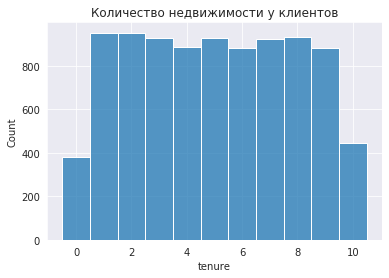

In [12]:
sns.histplot(data, x = 'tenure', discrete=True)
plt.title('Количество недвижимости у клиентов')

In [13]:
pd.set_option('precision', 5)
data.corr().tenure

creditscore       -0.00006
age               -0.01313
tenure             1.00000
balance           -0.00791
numofproducts      0.01198
hascrcard          0.02723
isactivemember    -0.03218
estimatedsalary    0.01052
exited            -0.01676
Name: tenure, dtype: float64

Возможная причина возникновения пропусков: пропуски в данном столбце скорее всего появляются при заполнении анкеты клиентом и вероятнее всего означают что у человека нет недвижимости. 

Пропусков 10% - поэтому при заполненнии данных нулями дальнейшие результаты могут сильно измениться.

Можно посмотреть как изменятся результаты работы моделей при удаленнии пропущенных значений и при заполении нулевым значением.
Для начала заменим пропуски на 0.

In [15]:
data['tenure'] = data['tenure'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(6), object(3)
memory usage: 937.6+ KB


#### Encoding признаков

`surname`      

Первый категориальный признак это фамилия. 
С одной стороны фамилия может означать принадлежность к одной семье – группе и содержать в себе полезную информацию. С другой стороны эти группы могут быть слишком специфичны, что приведет к переобучению модели. 

Посчитаем сколько всего уникальных фамилий в датасете:

In [16]:
data['surname'].nunique()

2932

Уникальных фамилий всего 2932. В датасете в среднем чуть больше 3 человек с одинаковой фамилией. Это могут быть как однафамильцы так и семьи.

Для того, чтобы в некоторых моделях попытаться использовать информацию из этого признака используем Ordinal Encoding.

In [17]:
encoder = OrdinalEncoder()

data['surname_ordinal'] = encoder.fit_transform(data['surname'].values.reshape(-1,1))
data.head()

,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,surname_ordinal
0,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,1115.0
1,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,1177.0
2,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,2040.0
3,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,289.0
4,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,1822.0


`geography` и `gender`

In [18]:
data['geography'].nunique()

3

In [19]:
data['gender'].nunique()

2

Для обработки этих признаков лучше всего подходит One-Hot Encoding. 

In [20]:
data_geography_ohe = pd.get_dummies(data['geography'], drop_first = True)
data_gender_ohe = pd.get_dummies(data['gender'], drop_first = True)
data_geography_ohe.head()

,Germany,Spain
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1


In [21]:
data = data.join(data_geography_ohe)
data = data.join(data_gender_ohe)

data.head(3)

,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,surname_ordinal,Germany,Spain,Male
0,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,1115.0,0,0,0
1,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,1177.0,0,1,0
2,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,2040.0,0,0,0


In [22]:
#удалим старые признаки и оформим столбцы
data = data.drop(['surname', 'geography', 'gender'], axis = 1)
data.columns = data.columns.str.lower()
data.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,surname_ordinal,germany,spain,male
0,619,42,2.0,0.00,1,1,1,101348.88,1,1115.0,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1177.0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,2040.0,0,0,0


Обработка категориальных признаков завершена. Далее нам предстоит нормализация количественных признаков, но перед этим мы должны разделить данные на выборки.

#### Разделение данных на обучающую, валидационную и тестовую выборки.

Для обучения модели, её валидации и проверки на тестовой выборке нам необходимы три типа выборок: обучающая, валидационная и тестовая. Исходные данные будем разбивать в соотношении 3:1:1.

Перед разделением укажем целевой и остальные признаки: 

In [23]:
features = data.drop(['exited'], axis = 1)
target = data['exited']

In [24]:
#сначала разделим на обучающую и временную части
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=RS)

#поделим временную выборку на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, stratify=target_temp, test_size=0.5, random_state=RS)

In [25]:
#проверим разделение
print(features_train.shape)
print(target_train.shape)

print(features_valid.shape)
print(target_valid.shape)

print(features_test.shape)
print(target_test.shape)

(6000, 12)
(6000,)
(2000, 12)
(2000,)
(2000, 12)
(2000,)


In [26]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,surname_ordinal,germany,spain,male
1403,739,27,6.0,0.00,1,1,1,57572.38,2176.0,0,0,0
5881,794,31,0.0,144880.34,2,0,1,175643.44,2003.0,0,1,1
2131,614,38,0.0,116248.88,1,1,0,105140.92,994.0,0,0,1
1352,535,48,5.0,134542.73,1,1,1,58203.67,2518.0,1,0,1
9774,679,42,1.0,0.00,2,0,0,71823.15,2660.0,0,0,1


#### Нормализация количественных признаков

Поскольку мы хотим посмотреть на результаты работы модели логистической регрессии, нам необходимо будет придать одинаковоый вес признакам, для этого будем использовать нормализацию.  
*`surname_ordinal` категориальный признак в числовом виде, поэтому при реализации модели логистической регрессии необходимо будет его убрать.

In [27]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,surname_ordinal,germany,spain,male
1403,0.778,0.12162,0.6,0.00000,0.00000,1,1,0.28783,2176.0,0,0,0
5881,0.888,0.17568,0.0,0.60775,0.33333,0,1,0.87824,2003.0,0,1,1
2131,0.528,0.27027,0.0,0.48765,0.00000,1,0,0.52570,994.0,0,0,1
1352,0.370,0.40541,0.5,0.56439,0.00000,1,1,0.29099,2518.0,1,0,1
9774,0.658,0.32432,0.1,0.00000,0.33333,0,0,0.35909,2660.0,0,0,1


### Вывод

На первом шаге мы подготовили наши данные для дальнейших исследований. 
1. Обработали дубликаты
2. Обработали пропуски
3. Произвели кодировку признаков
4. Разделили данные на обучающую, валидационную и тестовую выборки.
5. Нормализовали количественные признаки

## 2. Исследование задачи <a id='step2'></a>

Исследуем корреляцию признаков и баланс классов в целевом признаке.

Text(0.5, 1, 'Корреляция признаков')

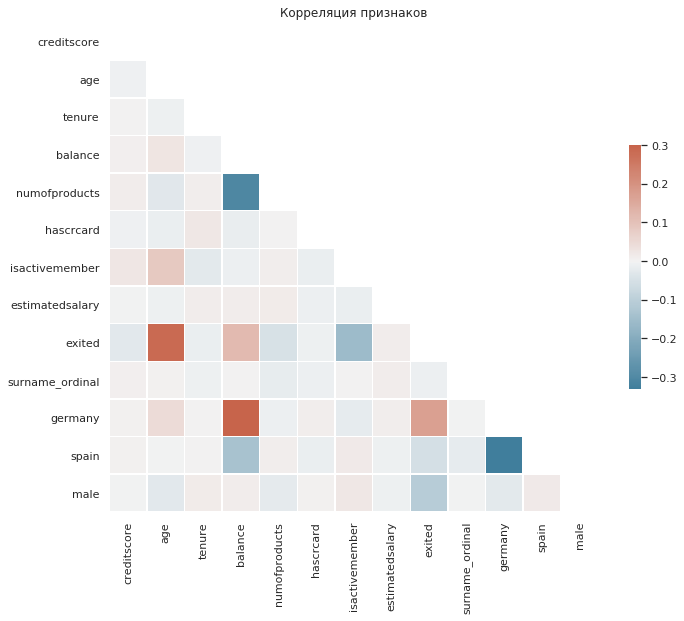

In [28]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Корреляция признаков')

В целом признаки мало коррелируют попарно между собой. 
Однако:  
1) У признака баланс есть положительная корреляция с страной проживания Германией и отрицательная с количеством продуктов.  
2) Отрицательная корреляция у страны проживания Германии и Испании - что логично, так как клиент, согласно нашим данным, может проживать только в одной стране.  
3) У целевого признака проявляется положительная корреляция с признаком возраст.

#### Распределение классов

Поскольку в целевом признаке есть только 2 исхода: клиент ушел (1) и клиент не ушел (0), мы решаем задачу бинарной классификации. 

Узнаем долю 1 (ушедших клиентов):

In [29]:
target_train.value_counts()[1] / target_train.value_counts()[0]

0.25575554625366265

Получаем что единиц примерно в 4 раза меньше чем 0.

#### Обучение модели без учета распределения классов

Начнем с RandomForestClassifier:

In [73]:
model = RandomForestClassifier( random_state = RS)
parameters = {'n_estimators': range (10, 101, 20),
              'max_depth': range (1, 13, 2),
              }

grid = GridSearchCVProgressBar(model, parameters, cv=5, n_jobs = -1, scoring='f1', verbose=1)

grid.fit(features_train, target_train)
print('Лучшие параметры:', grid.best_params_)
print('Лучшая средняя оценка:', grid.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучшие параметры: {'max_depth': 11, 'n_estimators': 30}
Лучшая средняя оценка: 0.5810740147447897


Наилучший f1-score, равный 0.58 мы получили при гиперпараметрах 'max_depth': 11, 'n_estimators': 30.
Проверим эти гиперпараметры на валидационной выборке:

In [74]:
model = RandomForestClassifier(oob_score = True, max_depth = 11, n_estimators = 30, random_state = RS)

model.fit(features_train, target_train)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.5316045380875203

Как видим, в случае несбалансированных классов GridsearchCV работает плохо – он находит средний F1 для всех классов, то есть если объекты класса 0 мы предсказываем хорошо, а единицы плохо, то F1 покажет "завышенный" усредненный результат.

На обучающей выборке лучший средний f1 = 0.58, а на валидационной - всего 0.53.

Confusion matrix:
[[1547   45]
 [ 244  164]]


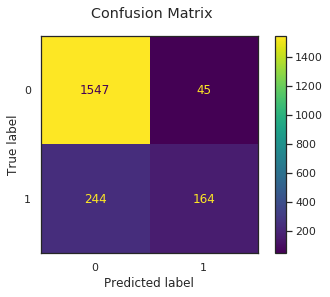

In [75]:
disp = plot_confusion_matrix(model, features_valid, target_valid)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

###### Согласно полученной матрице:  
*TruePositive = 164  
TrueNegative = 1547  
FalsePositive = 45  
FalseNegative = 244*  

Как видим, модель часто предсказывает ноль там, где его нет.

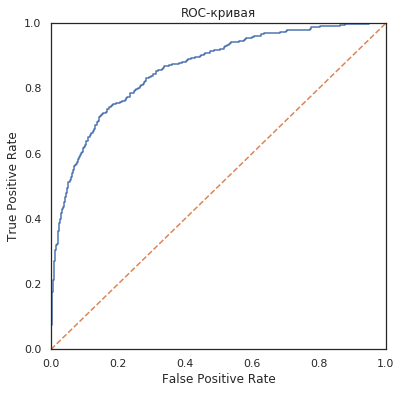

In [76]:
def roc_curve_plot():
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

    plt.figure(figsize=(6, 6))

    plt.plot(fpr, tpr)

    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    plt.title('ROC-кривая')

    plt.show()
    
roc_curve_plot()

In [77]:
def auc_roc_calc():
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    return 'AUC ROC score {:.4f}'.format(roc_auc_score(target_valid, probabilities_one_valid))
    
auc_roc_calc()

'AUC ROC score 0.8607'

Как видим, на давнном этапе маша модель уже предсказывает лучше случайной. AUC-ROC score 0.8607.

### Вывод

Наилучший f1-score равный 0.53 мы получили при гиперпараметрах модели случайного леса 'max_depth'= 11, 'n_estimators'= 30.
После построения ROC-кривой мы посчитали AUC ROC score: 0.86.

Поскольку нам нужно довести метрику F1 до 0.59, переходим к борьбе с дисбалансом.

## 3. Борьба с дисбалансом <a id='step3'></a>

#### Придание одинакового веса классам

In [35]:
model = RandomForestClassifier(class_weight='balanced', random_state = RS)
parameters = {'n_estimators': range (10, 201, 40),
              'max_depth': range (1, 13, 2),
              }

grid = GridSearchCVProgressBar(model, parameters, cv=5, n_jobs = -1, scoring='f1', verbose=1)

grid.fit(features_train, target_train)
print('best_params:', grid.best_params_)
print('best_score:', grid.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
best_params: {'max_depth': 9, 'n_estimators': 50}
best_score: 0.6168233055622226


In [36]:
model = RandomForestClassifier(class_weight='balanced', max_depth = 9, n_estimators = 50, random_state = RS)

model.fit(features_train, target_train)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.6327944572748267

Получаем уже хороший f1 равный 0.63.

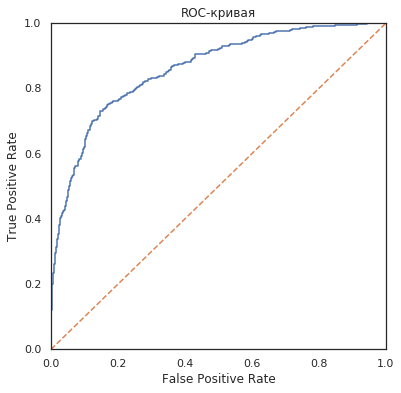

In [37]:
roc_curve_plot()

In [38]:
auc_roc_calc()

'AUC ROC score 0.8607'

Результаты уже довольно хорошие, можем попробовать улучшить f1 score дальше.

#### Уменьшение выборки

In [39]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
features_downsampled.shape

(2416, 12)

In [40]:
model = RandomForestClassifier(class_weight='balanced', random_state = RS)
parameters = {'n_estimators': range (10, 201, 40),
              'max_depth': range (1, 13, 2),
              }

grid = GridSearchCVProgressBar(model, parameters, cv=5, n_jobs = -1, scoring='f1', verbose=1)

grid.fit(features_downsampled, target_downsampled)
print('best_params:', grid.best_params_)
print('best_score:', grid.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
best_params: {'max_depth': 11, 'n_estimators': 130}
best_score: 0.7662860629831588


In [79]:
model = RandomForestClassifier(class_weight='balanced', max_depth = 11, n_estimators = 130, random_state = RS)

model.fit(features_downsampled, target_downsampled)
predictions = model.predict(features_valid)
print(f1_score(target_valid, predictions))

0.59375


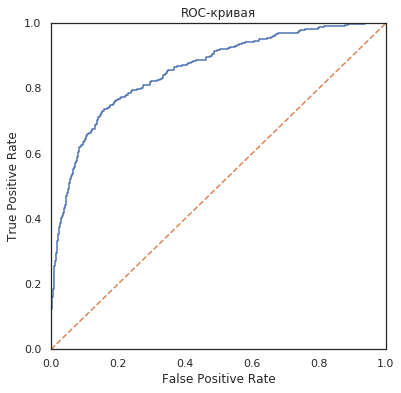

In [42]:
roc_curve_plot()

In [43]:
auc_roc_calc()

'AUC ROC score 0.8557'

F1 упал до 0.59, по всей видимости модели не хватает данных для обучения.

##### DecisionTreeClassifier

In [44]:
model = DecisionTreeClassifier(class_weight='balanced', random_state = RS)
parameters = {'max_depth': range (1, 15, 1),
              }

grid = GridSearchCVProgressBar(model, parameters, cv=5, n_jobs = -1, scoring='f1', verbose=1)

grid.fit(features_downsampled, target_downsampled)
print('best_params:', grid.best_params_)
print('best_score:', grid.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
best_params: {'max_depth': 5}
best_score: 0.7577370939506256


In [93]:
model = DecisionTreeClassifier(class_weight='balanced', max_depth = 5, random_state = RS)

model.fit(features_downsampled, target_downsampled)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.5437392795883362

Confusion matrix:
[[1151  441]
 [  91  317]]


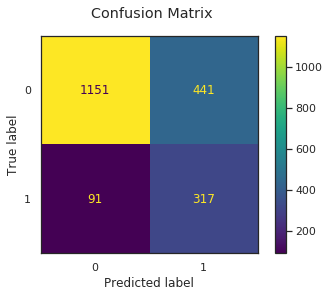

In [94]:
disp = plot_confusion_matrix(model, features_valid, target_valid)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

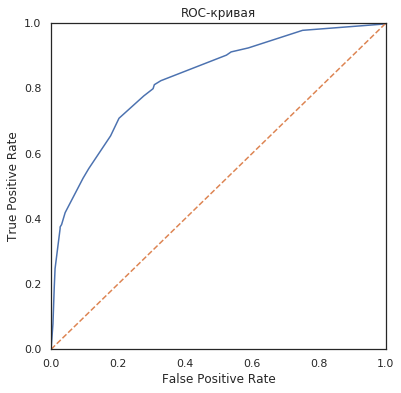

In [47]:
roc_curve_plot()

In [48]:
auc_roc_calc()

'AUC ROC score 0.8273'

Дерево решений также показывает себя не очень. Мы стали получать score ниже требуемого. 

#### Увеличение выборки

In [49]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
target_upsampled.value_counts()

1    4888
0    4778
Name: exited, dtype: int64

На этот раз у нас больше данных, посмотрим как будут обучаться модели.
Сначала попробуем посмотреть на работу модели без GridSearch, с визуализацией результатов.

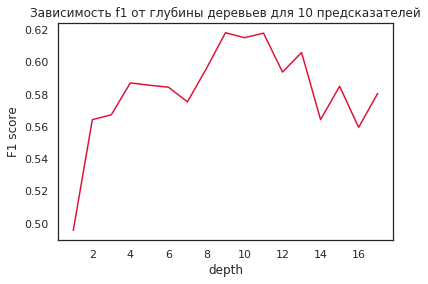

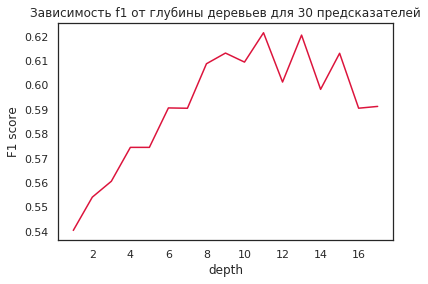

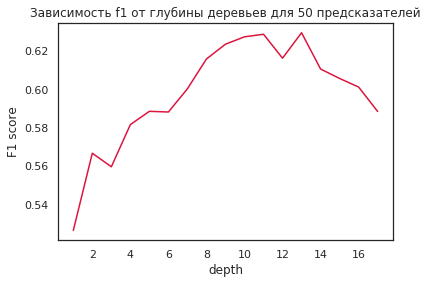

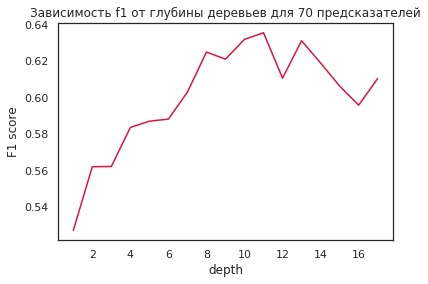

F1 score наилучшей модели на валидационной выборке: 0.6353211009174311 Лучшее количество деревьев: 70 Лучшая глубина: 11


In [50]:
#функция для визуализации результатов обучения
def scores_plot(depth_row, f1_scores, n_est):
    g = plt.plot(depth_row, 
         f1_scores,  
         f'#DC143C'        
         )     

    plt.xlabel('depth')
    plt.ylabel('F1 score')
    plt.title(f"Зависимость f1 от глубины деревьев для {n_est} предсказателей")
    plt.show()


best_model = None
best_result = 0
best_depth = 0
best_est = 0
for est in range(10, 71, 20):
    depth_row = []
    f1_scores = []
    for depth in range (1, 18):    
        model = RandomForestClassifier(random_state=RS, n_estimators=est, max_depth=depth) 
        model.fit(features_upsampled, target_upsampled)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions) 
        depth_row.append(depth)
        f1_scores.append(result)
        
        if result > best_result:
            best_model = model
            best_result = result 
            best_est = est
            best_depth = depth
            
    scores_plot(depth_row, f1_scores, est)
    
    
print("F1 score наилучшей модели на валидационной выборке:", best_result, 
      "Лучшее количество деревьев:", best_est, 
      "Лучшая глубина:", best_depth)

Построив графики, становится видно, что при глубине большей 11 модель начинать работать нестабильно. Поэтому будем ограничивать глубину 11.

In [80]:
model = RandomForestClassifier(class_weight='balanced', random_state = RS)
parameters = {'n_estimators': range (10, 201, 40),
              'max_depth': range (1, 12, 2),
              }

grid = GridSearchCVProgressBar(model, parameters, cv=5, n_jobs = -1, scoring='f1', verbose=1)

grid.fit(features_upsampled, target_upsampled)
print('best_params:', grid.best_params_)
print('best_score:', grid.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
best_params: {'max_depth': 11, 'n_estimators': 170}
best_score: 0.8989628977731876


In [96]:
model = RandomForestClassifier(n_estimators=170, max_depth = 11, random_state = RS)

model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.6405529953917051

Получен новый лучший результат: F1 = 0.64

Feature ranking:
1. feature 1 (0.297659)
2. feature 4 (0.182431)
3. feature 3 (0.107978)
4. feature 0 (0.077973)
5. feature 8 (0.077676)
6. feature 7 (0.077293)
7. feature 6 (0.052356)
8. feature 2 (0.043046)
9. feature 9 (0.041313)
10. feature 11 (0.019780)
11. feature 5 (0.011528)
12. feature 10 (0.010968)


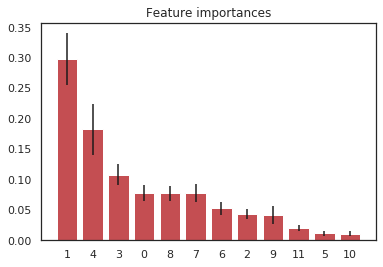

In [89]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(features.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(features.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(features.shape[1]), indices)
plt.xlim([-1, features.shape[1]])
plt.show()

Согласно построенной модели, самую большую значимость имеют feature 1 (возраст) и f4 (количество продуктов банка). 

Confusion matrix:
[[1410  182]
 [ 130  278]]


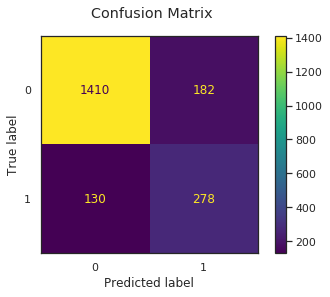

In [90]:
disp = plot_confusion_matrix(model, features_valid, target_valid)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

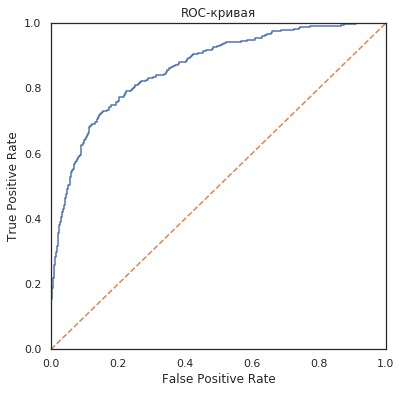

In [91]:
roc_curve_plot()

In [92]:
auc_roc_calc()

'AUC ROC score 0.8632'

Upsampling позволил улучшить реультат: F1 0.64,  AUC-ROC-score 0.8632 у модели Случайного леса с 170  предскзателями и глубиной 11.

##### DecisionTreeClassifier

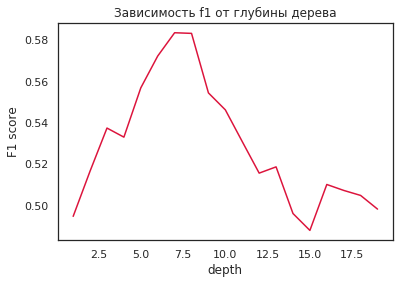

F1 score наилучшей модели на валидационной выборке: 0.5834829443447037 Лучшая глубина: 7


In [87]:
#функция для визуализации результатов обучения
def scores_plot(depth_row, f1_scores):
    g = plt.plot(depth_row, 
         f1_scores,  
         f'#DC143C'        
         )     

    plt.xlabel('depth')
    plt.ylabel('F1 score')
    plt.title(f"Зависимость f1 от глубины дерева")
    plt.show()


best_model = None
best_result = 0
best_depth = 0

depth_row = []
f1_scores = []
for depth in range (1, 20):    
    model = DecisionTreeClassifier(class_weight='balanced', random_state=RS, max_depth=depth) 
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions) 
    depth_row.append(depth)
    f1_scores.append(result)
    if result > best_result:
        best_model = model
        best_result = result 
        best_depth = depth
            
scores_plot(depth_row, f1_scores)
    
    
print("F1 score наилучшей модели на валидационной выборке:", best_result, 
      "Лучшая глубина:", best_depth)

Модель решающего дерева в этой задаче показывает себя хуже: самый большой F1 = 0.58 получаем при максимальной глубине равной 7.

Самые хорошие результаты показывает Upsampling для Случайного леса (с 170  предскзателями и глубиной 11). Теперь будем пробовать изменять порог вместе с использованием Upsampling. 

#### Изменение порога

In [101]:
model = RandomForestClassifier(n_estimators=170, max_depth = 11, random_state = RS)

model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.4, 0.6, 0.01):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.4f}".format(
        threshold, precision, recall, f1))

Порог = 0.40 | Точность = 0.496, Полнота = 0.762, F1 = 0.6010
Порог = 0.41 | Точность = 0.502, Полнота = 0.750, F1 = 0.6018
Порог = 0.42 | Точность = 0.513, Полнота = 0.748, F1 = 0.6088
Порог = 0.43 | Точность = 0.523, Полнота = 0.733, F1 = 0.6102
Порог = 0.44 | Точность = 0.533, Полнота = 0.730, F1 = 0.6163
Порог = 0.45 | Точность = 0.546, Полнота = 0.728, F1 = 0.6239
Порог = 0.46 | Точность = 0.558, Полнота = 0.718, F1 = 0.6281
Порог = 0.47 | Точность = 0.566, Полнота = 0.706, F1 = 0.6281
Порог = 0.48 | Точность = 0.573, Полнота = 0.696, F1 = 0.6283
Порог = 0.49 | Точность = 0.585, Полнота = 0.691, F1 = 0.6337
Порог = 0.50 | Точность = 0.604, Полнота = 0.681, F1 = 0.6406
Порог = 0.51 | Точность = 0.603, Полнота = 0.659, F1 = 0.6300
Порог = 0.52 | Точность = 0.617, Полнота = 0.647, F1 = 0.6316
Порог = 0.53 | Точность = 0.627, Полнота = 0.627, F1 = 0.6275
Порог = 0.54 | Точность = 0.640, Полнота = 0.618, F1 = 0.6284
Порог = 0.55 | Точность = 0.639, Полнота = 0.593, F1 = 0.6150
Порог = 

Как становится видно, модель имеет наибольший score при пороге ровно в 0.5. Более высокого F1 здесь добиться не получится.

In [110]:
#ячейка для работы с состоянием
#dill.dump_session('6th_project_env.db')
#dill.load_session('6th_project_env.db')

#####  Модель Логистической регресии

Удалим категориальный признак 

In [102]:
features = data.drop(['exited', 'surname_ordinal'], axis = 1)
target = data['exited']

features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=RS)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, stratify=target_temp, test_size=0.5, random_state=RS)

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [107]:
model = LogisticRegression(class_weight='balanced', random_state = RS, solver = 'liblinear')

model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.4514003294892915

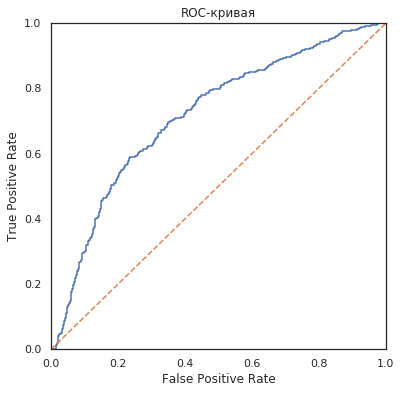

In [104]:
roc_curve_plot()

In [105]:
auc_roc_calc()

'AUC ROC score 0.7164'

Модель логистической регрессии быстро работает, но показывает не лучшие результаты.

### Вывод

На данном этапе мы боролись с неравномерным распределением классов различными способами:

 • Оценивали работу моделей Случайного леса, Дерева решений и Логистической регрессии.  
 • Сначала мы придали классам одинаковый вес.   
 • После провели downsampling нулевого класса.   
 • Далее изменяли размер классов с помощью upsampling-а.  
 • В конце мы попробовали изменить вероятностный порог предсказания класса. F1-score не изменился.  

Самая успешная модель – модель Случайного леса с 170  предскзателями и глубиной 11, при использовании upsampling-а классов.
Самый высокий F1-score которого получилось достичь 0.6406.

## 4. Тестирование модели <a id='step4'></a>

Тестируем лучшую модель на тестовой выборке и сравниваем её с dummy-моделью.

In [72]:
#dill.load_session('6th_project_env.db')

In [111]:
model = RandomForestClassifier(n_estimators=170, max_depth = 11, random_state = RS)

model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)
f1_score(target_test, predictions)

0.5997638724911452

На тестовой выборке F1 падает с 0.6406 до 0.5998. 
Удалось достичь необходимого F1 в 0.59.

In [113]:
model = DummyClassifier(strategy="prior", random_state = RS)

model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)
f1_score(target_test, predictions)

0.3381803074366431

F1 dummy модели 0.3382, у нашей модели больше. Таким образом проверка на адекватность пройдена.

## Общий вывод <a id='step5'></a>

**1.** На первом шаге мы подготовили наши данные для дальнейших исследований: 
1. Обработали дубликаты
2. Обработали пропуски
3. Произвели кодировку признаков
4. Разделили данные на обучающую, валидационную и тестовую выборки.
5. Нормализовали количественные признаки

**2.** На втором шаге мы обучали модель без учета дисбаланса классов.  

Наилучший f1-score, равный 0.53 мы получили при гиперпараметрах модели случайного леса 'max_depth'= 11, 'n_estimators'= 30.  
После построения ROC-кривой мы посчитали AUC ROC score: 0.86.

Поскольку нам нужно было довести метрику F1 до 0.59, мы перешли к различным способам борьбы с дисбалансом.

**3.** При борьбе с дисбалансом мы:  

 • Оценивали работу моделей Случайного леса, Дерева решений и Логистической регрессии.  
 • Сначала мы придали классам одинаковый вес. Лучший F1-score стал: 0.63   
 • После провели downsampling нулевого класса. Лучший F1-score на данном этапе был: 0.59   
 • Далее изменяли размер классов с помощью upsampling-а. Лучший F1-score: 0.64  
 • В конце мы попробовали изменить вероятностный порог предсказания класса. F1-score не изменился.  

**4.** На последнем шаге мы провели тестирование лучшей модели:  

Модель Случайного леса с 170  предскзателями и глубиной 11, при использовании upsampling-а классов получила F1-score = 0.60.  
Для оценки адекватности модели мы сравнивали её с dummy-моделью, которая имела F1-score = 0.34.